# Passing Network Chart

This tutorial will demonstrate how to process the data and create a simplified version of the passing network chart that [@mclachbot](https://x.com/mclachbot).  In this chart, each dot represents a player's average position in the match.  The size of the dot is representative of how many times the player has touched the ball. The lines between any two players indicate passes between that pair, with the thickness of the line indicating how many passes in total were made between them. 

There is a couple of different ways you can aggregate players in this form of chart.  You can treat each player individually, but this means that once a sub is made, your chart no longer works (or you end up with more than 11 dots on your chart).  I prefer aggregating across positions, so that if a sub is made, the original player and the sub are mushed together (assuming they keep the same position).  This works well as long as there are no formation changes.  Overall, though, formation changes are rarer than substitions, which is why I prefer this approach.  This tutorial will aggregate players across positions as well.

For simplicity sake, we will only use pass events to construct the chart in this example, but one can be flexible with which event types are used to determine the average player position based on what they want to show

## Data Loading

We will load an example data file into a dataframe first. The file has the following format

```period,minute,second,player_name,is_successful,x,y,end_x,end_y,position,pass_receiver,pass_receiver_position,formation
1,0,7,levi colwill,1,26.7,63.3,26.4,83.4,LCB,marc cucurella,LB,4231
1,0,9,marc cucurella,0,25.9,84.6,43.6,62.9,LB,,,4231
1,0,23,malo gusto,1,9.7,4.3,24.9,7.1,RB,noni madueke,RM,4231
1,0,39,wesley fofana,1,23.3,17.8,9.1,37.4,RCB,robert sanchez,GK,4231
```

Each row represents an event and contains the following data
 - period: which period the event took place in.
 - minute: which minute of the game the event took place in.
 - second: which second of the game the event took place in.
 - player_name: The name of the player making the pass
 - is_successful: 1 if the pass is completed, 0 if not
 - x: x coordinate of the start of the pass
 - y: y coordinate of the start of the pass
 - end_x: x coordinate of the end of the pass
 - end_y: y coordinate of the end of the pass
 - position: passing player position
 - pass_receiver: the name of the pass receipient
 - pass_receiver_position: the pass recepient's position
 - formation: the formation of the team







In [1]:
import pandas as pd
import numpy as np  

data = pd.read_csv('../data/pass_network.csv', index_col=0)
data.head()

,minute,second,player_name,is_successful,x,y,end_x,end_y,position,pass_receiver,pass_receiver_position,formation
period,,,,,,,,,,,,
1,0,7,levi colwill,1,26.7,63.3,26.4,83.4,LCB,marc cucurella,LB,4231
1,0,9,marc cucurella,0,25.9,84.6,43.6,62.9,LB,NaN,NaN,4231
1,0,23,malo gusto,1,9.7,4.3,24.9,7.1,RB,noni madueke,RM,4231
1,0,39,wesley fofana,1,23.3,17.8,9.1,37.4,RCB,robert sanchez,GK,4231
1,0,43,robert sanchez,1,9.1,37.4,15.9,69.0,GK,levi colwill,LCB,4231


## Data Processing

Next, we will define functions that will generate the average touch location and count of touches of every player, grouped by that player's position and also the number of passes between any pair of players, again, grouped by position.  We will also filter the data to make sure only data generated while the team was playing in its starting formation is used

In [2]:
import pandas as pd
def initial_data_clean(data:pd.DataFrame)->pd.DataFrame:
    """
    This function filters the data to the initial formation of the team. It also shortens 
    some of the position names.
    """
    data = data[data['formation']==data[data['formation'].notnull()]['formation'].iloc[0]].copy()
    data['position'] = data['position'].apply(lambda x: x.replace('C','') if len(x)==4 else x)
    data['pass_receiver_position'] = data['pass_receiver_position'].apply(lambda x: x.replace('C','') if isinstance(x, str) and len(x)==4 else x)
    return data

def aggregate_touches(data:pd.DataFrame)->pd.DataFrame:
    """
    This function aggregates the touches of each player
    """
    data = data.groupby(['position']).agg({'x':'mean','y':'mean','player_name':'count'}).reset_index().rename(columns={'player_name':'touches'})
    return data

def aggregate_pass_pairs(data:pd.DataFrame)->pd.DataFrame:
    """
    This function aggregates the pass pairs.  We will also filter out 
    any incomplete passes. Finally we need to combine the pairs so that x->y and y->x are combined
    """
    data = data[data['is_successful']==1]
    data = data.groupby(['position','pass_receiver_position']).agg({'x':'count'}).reset_index().rename(columns={'x':'passes'})
    data['player_1_position'] = data.apply(lambda x: min(x['position'],x['pass_receiver_position']),axis=1)
    data['player_2_position'] = data.apply(lambda x: max(x['position'],x['pass_receiver_position']),axis=1)
    data = data.groupby(['player_1_position','player_2_position']).agg({'passes':'sum'}).reset_index()
    return data

In [3]:
player_locations = initial_data_clean(data).pipe(aggregate_touches)
player_locations.head()

,position,x,y,touches
0,CAM,61.251613,45.754839,31
1,CF,77.460000,64.080000,5
2,GK,16.400000,48.512121,33
3,LB,50.815942,85.013043,69
4,LCB,38.173256,64.066279,86


In [4]:
pass_pairs = initial_data_clean(data).pipe(aggregate_pass_pairs)
pass_pairs.head()

,player_1_position,player_2_position,passes
0,CAM,CF,2
1,CAM,GK,2
2,CAM,LB,5
3,CAM,LCB,9
4,CAM,LDM,6


## Plot Data

Now that we have our data, we will plot it on the pitch.  We will use `mplsoccer` library to plot the pitch, then place annotated circles to indicate the average location of the player.  Then we will connect each pair of players with a line, whose thickness will be determined by the number of passes.  But first, we will set up some visualisation parameters

In [5]:
visualisation_parameters = {
    'facecolor':'oldlace',
    'text_color':'white',
    'chart_color':'blue',
    'pass_line_color':'blue',
    'line_color':'grey',
    'min_dot_size':200,
    'max_dot_size':1000,
    'min_line_width':0.5,
    'max_line_width':10,
    'min_passes_to_show':5,
    'max_pass_line_opacity':0.9,
    'min_pass_line_opacity':0.1
}

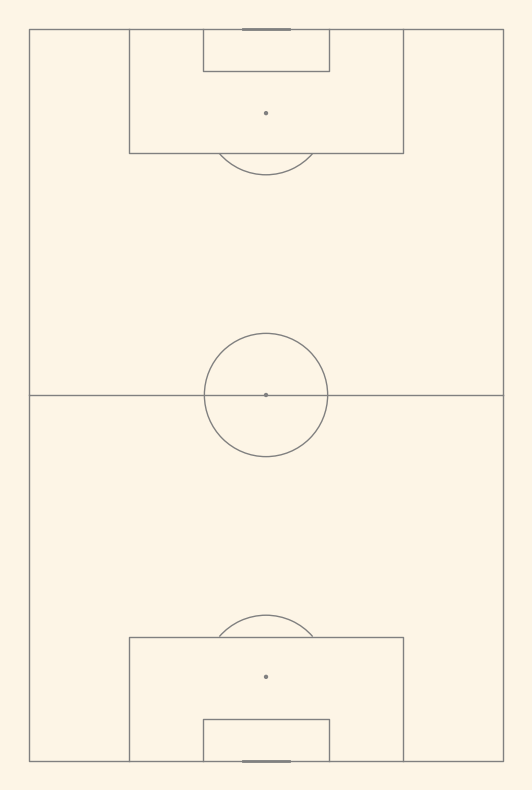

In [6]:
from mplsoccer.pitch import VerticalPitch
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib inline


def set_up_pitch(visualisation_parameters):
    pitch = VerticalPitch(
        pitch_type='opta',
        pitch_color=visualisation_parameters['facecolor'],
        line_color=visualisation_parameters['line_color'],
        linewidth=1
    )
    figure = Figure(figsize=(7,10), facecolor=visualisation_parameters['facecolor'])
    ax = figure.add_subplot(1,1,1)
    pitch.draw(ax=ax)
    return pitch, figure, ax

pitch, figure, ax = set_up_pitch(visualisation_parameters)
figure


Next, the function to place the individual dots that represent the average player position on the pitch

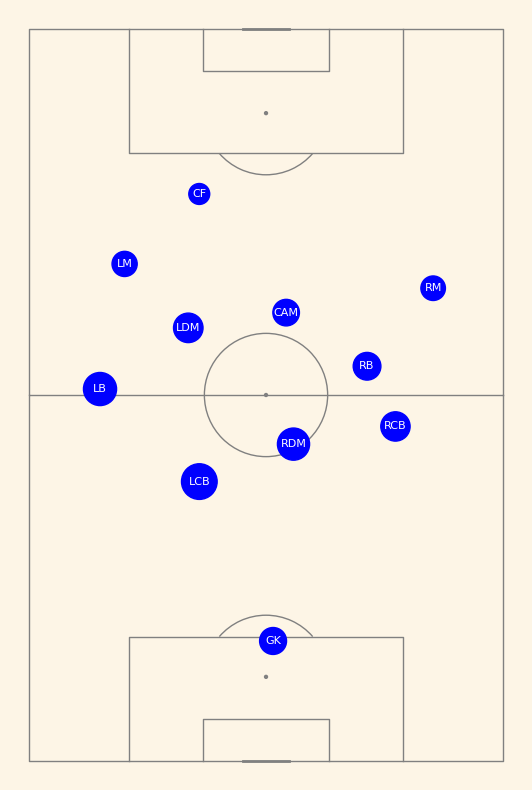

In [7]:
def plot_average_positions(
    data:pd.DataFrame, pitch:VerticalPitch, ax:Axes, visualisation_parameters:dict
)->None:
    """
    This function plots the average positions of the players
    """
    MAX_SIZE_TOUCHES = 150

    x = data['x']
    y = data['y']
    s = [visualisation_parameters['min_dot_size'] + (t/MAX_SIZE_TOUCHES)*(visualisation_parameters['max_dot_size'] - visualisation_parameters['min_dot_size'])
         for t in data['touches']]
    pitch.scatter(x, y, s=s, color=visualisation_parameters['chart_color'], ax=ax, zorder=3)
    for _, row in data.iterrows():
        x = row['x']
        y = row['y']
        position = row['position']
        pitch.annotate(position, (x, y), ax=ax, fontsize=8, color=visualisation_parameters['text_color'], ha='center', va='center', zorder=4)    


plot_average_positions(player_locations, pitch, ax, visualisation_parameters)
figure

Finally, we add the pass lines to the pitch. We will also adjust the opacity of the lines based on the number of passes between the players.

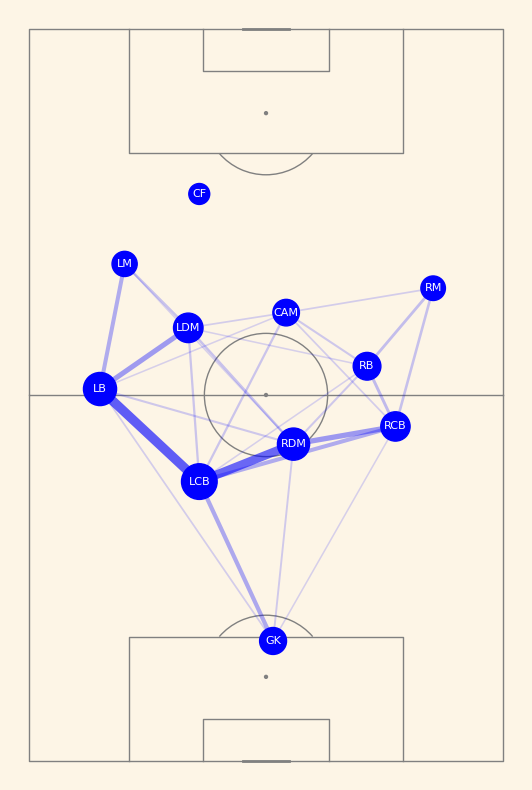

In [8]:
def plot_passing_lines(
    pass_data:pd.DataFrame, player_location_data:pd.DataFrame,  pitch:VerticalPitch, ax:Axes, visualisation_parameters:dict
)->None:
    MAX_SIZE_PASSES = 75
    for _, row in pass_data.iterrows():
        if row['passes']<visualisation_parameters['min_passes_to_show']:
            continue

        player_1 = row['player_1_position']
        player_2 = row['player_2_position']
        passes = row['passes']
        player_1_x = player_location_data[player_location_data['position']==player_1]['x'].values[0]
        player_1_y = player_location_data[player_location_data['position']==player_1]['y'].values[0]
        player_2_x = player_location_data[player_location_data['position']==player_2]['x'].values[0]
        player_2_y = player_location_data[player_location_data['position']==player_2]['y'].values[0]
        line_width = visualisation_parameters['min_line_width'] + (passes/MAX_SIZE_PASSES)*(visualisation_parameters['max_line_width'] - visualisation_parameters['min_line_width'])
        line_opacity = visualisation_parameters['min_pass_line_opacity'] + (passes/MAX_SIZE_PASSES)*(visualisation_parameters['max_pass_line_opacity'] - visualisation_parameters['min_pass_line_opacity'])
        pitch.lines(player_1_x, player_1_y, player_2_x, player_2_y, lw=line_width, color=visualisation_parameters['pass_line_color'], ax=ax, zorder=2, alpha=line_opacity)

plot_passing_lines(pass_pairs, player_locations, pitch, ax, visualisation_parameters)
figure